# Custom Transformer

In [3]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import set_config; set_config(display='diagram')

👇 Consider the following dataset

In [4]:
import pandas as pd

data = pd.read_csv("data.csv")
data.head()

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm,days_until_delivery
0,RJ,SP,1825,53,10,40,9
1,RJ,SP,700,65,18,28,9
2,RJ,SP,1825,53,10,40,11
3,RJ,SP,1825,53,10,40,12
4,RJ,SP,1825,53,10,40,14


In [74]:
X_train

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40
1,RJ,SP,700,65,18,28
2,RJ,SP,1825,53,10,40
3,RJ,SP,1825,53,10,40
4,RJ,SP,1825,53,10,40
...,...,...,...,...,...,...
895,PR,SP,6325,37,41,37
896,PA,SP,1825,44,14,34
897,SP,SP,8000,53,74,18
898,RJ,SP,13867,101,8,57


In [150]:
X = data.drop(columns='days_until_delivery')
y = data['days_until_delivery']

X_train = X[:900]
y_train = y[:900]
X_test = X[900:]
y_test = y[900:]

In [114]:
X_train.dtypes

customer_state       object
seller_state         object
product_weight_g      int64
product_length_cm     int64
product_height_cm     int64
product_width_cm      int64
dtype: object

- Each observation of the dataset represents an item being delivered from a  `seller_state` to a `customer_state`. 
- Other columns describe the packaging properties of each item.

🎯 The target is the number of days between the order and the delivery.

<AxesSubplot:xlabel='days_until_delivery', ylabel='Count'>

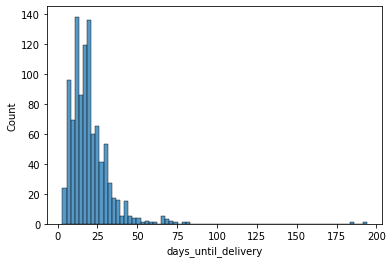

In [5]:
# Check target
sns.histplot(data.days_until_delivery)

## 1. Pipeline

👇 Create a scikit-learn pipeline named `pipe`:

- Engineer a `volume` feature from the dimensions features
- Preserve the original product dimensions features for training
- Scale all numerical features
- Encode the categorical features
- Add a default `Ridge` regression estimator

<details><summary>Hints</summary>

- There are many ways to create your preprocessed matrix (using `ColumnTransformer` and/or `FeatureUnion`). 
    
- If your transformed feature matrix look wierd, it may be stored as "sparse" by the default behavior of `OneHotEncoder(sparse=True)`. Use `.todense()` to turn it back to a dense matrix

</details>

In [86]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Preprocessor

volume_constructor = FunctionTransformer(lambda df: pd.DataFrame(df["product_length_cm"] * df["product_height_cm"] * df['product_width_cm']))

num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

# Encode categorical values
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Parallelize "num_transformer" and "cat_transfomer"

preprocessor = make_column_transformer(
    (num_transformer, ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']),
    (cat_transformer, ['seller_state']),
    remainder='passthrough'
)

# SimpleImputer.get_feature_names_out = (lambda self, names = None: self.feature_names_in_)

# preprocessor.fit(X_train)
# X_train_transformed = preprocessor.transform(X_train)
# preprocessor.get_feature_names_out()
preproc_full = make_union(preprocessor, volume_constructor)
# preproc_full

pipe = make_pipeline(preproc_full, Ridge())
pipe
# display(X_train.head(3))
# pd.DataFrame(X_train_transformed).head(3)
# preproc_full

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('columntransformer',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('pipeline',
                                                                                  Pipeline(steps=[('scaler',
                                                                                                   StandardScaler())]),
                                                                                  ['product_weight_g',
                                                                                   'product_length_cm',
                                                                                   'product_height_cm',
                                                                                   'product_width_cm']),
                                                                                 ('onehotencoder',
                                                                                  OneHotEncoder(handle_unknown='ignore'),
                                                                                  ['seller_state'])])),
                                                ('functiontransformer',
                                                 FunctionTransformer(func=<function <lambda> at 0x12cc6c8c0>))])),
                ('ridge', Ridge())])

In [165]:
# enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
# enc.fit(X_train[['customer_state']])
# enc.categories_

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def multiply(df):
    return pd.DataFrame(
        df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm'])
    
volume_computer = Pipeline([
    ('compute_volume', FunctionTransformer(multiply)),
    ('scale_volume', MinMaxScaler())
])

cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
cat_col = make_column_selector(dtype_include=['object'])
num_col = make_column_selector(dtype_include=['int64'])

preprocessor = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough'
)

union = FeatureUnion([
    ('preprocess', preprocessor), # columns 0-8
    ('compute_volume', volume_computer) # new colum 9
])

pipe = make_pipeline(union, Ridge())
# pipe = make_pipeline(volume_computer, preproc_basic)

# volume_computer.fit(X_train)
# pipe.transform(X_train[['customer_state']])

pipe.fit(X_train, y_train)

# display(X_train.head(3))
# display(pd.DataFrame(X_train_transformed).head(3))

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('preprocess',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('columntransformer',
                                                                                  ColumnTransformer(transformers=[('columntransformer',
                                                                                                                   ColumnTransformer(transformers=[('columntransformer',
                                                                                                                                                    ColumnTransformer(transformers=[('columntransformer',
                                                                                                                                                                                     ColumnTransformer(transformers=[('col...
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12ca9b2d0>),
                                                                                 ('onehotencoder',
                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                sparse=False),
                                                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12cd3e450>)])),
                                                ('compute_volume',
                                                 Pipeline(steps=[('compute_volume',
                                                                  FunctionTransformer(func=<function multiply at 0x12cd94b90>)),
                                                                 ('scale_volume',
                                                                  MinMaxScaler())]))])),
                ('ridge', Ridge())])

In [167]:
display(pd.DataFrame(union.fit_transform(X_train)).head(3))

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-1.151475,0.013818,-1.376550,0.731243,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.075199
1,-1.350053,1.015395,-1.005998,-0.235394,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.121439
2,-1.151475,0.013818,-1.376550,0.731243,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.075199


In [169]:
pipe.fit(X_train, y_train)
pipe.predict(X_test.iloc[0:2])

# Score model
pipe.score(X_test,y_test)

0.24190796520164604

In [170]:
new_data = pd.read_csv("data_new.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


#### 🧪 Test your pipe

In [14]:
from nbresult import ChallengeResult

pipe_test = pipe

# Check that it doesn't crash
assert pipe_test.fit(X,y)

result = ChallengeResult('pipe', 
                         shape = pipe_test[:-1].fit_transform(X).shape
)
result.write()
print(result.check())

## 2. Train and Predict

👇 Let's imagine `data` is your entire training set.

- `cross_validate` your pipeline on this dataset (❗️low r2 score are expected)
- Now, imagine you just received an new order `new_data`: predict it's duration of delivery in a variable `prediction`

In [15]:
new_data = pd.read_csv("data_new.csv")
new_data

,customer_state,seller_state,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,RJ,SP,1825,53,10,40


In [ ]:
# YOUR CODE HERE

In [ ]:
from nbresult import ChallengeResult

result = ChallengeResult('prediction',
    prediction = prediction
)
result.write()
print(result.check())


🏁 Congratulation. Don't forget to add, commit and push your notebook.